<a href="https://colab.research.google.com/github/paulaassisb/projeto-final-ds-awari/blob/main/Projeto_Awari_Paula_Assis_(v2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [472]:
## Importação de bibliotecas
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import re
import unicodedata
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import seaborn as sns
## import matplotlib.pyplot as plt

###1. Importação da base de dados

In [473]:
## Importando arquivo da coleta de dados
dados_quest = pd.read_csv('https://raw.githubusercontent.com/paulaassisb/projeto-final-ds-awari/main/coleta_dados_quest_projeto_final_indices.csv', sep = ';', encoding='latin-1')
print(f'Número de linhas: {len(dados_quest)}')
print(f'Número de colunas: {len(dados_quest.columns)}')


Número de linhas: 3778
Número de colunas: 21


In [474]:
## Transformando em DataFrame para visualização e manipulação dos dados
df = pd.DataFrame(dados_quest)

In [475]:
df.head()

,Numero do Sujeito,1a. Doença,Idade 1a. Doença,Tempo 1a Doença,Sexo,UF Nascimento,UF,Formação,Atividade,Escolaridade,Estado Civil,Religião,Outro Idioma,Análise do Contexto,Autoconfiança,Autocontrole,Conquistar e Manter Pessoas,Empatia,Leitura Corporal,Otimismo com a Vida,Sentido da Vida
0,13531.0,Depressão,31 - 49 anos,Um ano,Feminino,SP,SP,Administradora,Gerente de Compras,Pós-Graduação,Casado,Católico,Sim,0.92,15.15,17.17,2.78,13.07,7.04,3.79,0.92
1,13532.0,enfermidade que me levou a 15 dias de hospital...,7 - 12 anos,Mais de um ano,Masculino,SP,SP,Arquiteto,NaN,Pós-Graduação,Casado,Evangélico,Sim,6.03,12.12,18.18,2.78,1.01,2.76,6.06,-4.04
2,13533.0,Violência doméstica,7 - 12 anos,Mais de um ano,Masculino,SP,SP,NaN,Pesquisa e leitura de livros,Superior Completo,Solteiro,Outro,Não,0.92,3.79,-3.03,-1.98,-0.92,-0.92,4.80,0.92
3,13534.0,Nenhuma resposta,Nenhuma resposta,Nenhuma resposta,Masculino,SP,SP,Administração de Empresas,Analista de Mercado,Superior Completo,Solteiro,Evangélico,Sim,7.04,15.15,17.17,3.79,4.77,0.00,1.77,0.92
4,13535.0,Nenhuma resposta,Nenhuma resposta,Nenhuma resposta,Masculino,SP,SP,NaN,NaN,Superior Incompleto,Solteiro,Evangélico,Sim,5.86,6.82,5.81,6.06,4.02,0.00,4.80,5.86


###2. Preparação da base de dados


**Transformando as colunas**

In [476]:
df.columns

Index(['Numero do Sujeito', '1a. Doença', 'Idade 1a. Doença',
       'Tempo 1a Doença', 'Sexo', 'UF Nascimento', 'UF', 'Formação',
       'Atividade', 'Escolaridade', 'Estado Civil', 'Religião', 'Outro Idioma',
       'Análise do Contexto', 'Autoconfiança', 'Autocontrole',
       'Conquistar e Manter Pessoas', 'Empatia', 'Leitura Corporal',
       'Otimismo com a Vida', 'Sentido da Vida'],
      dtype='object')

In [477]:
## Nomes das colunas (todos em minúsculo e sem espaço)
df.columns.str.lower()
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [478]:
## Renomear colunas relacionadas a doença/trauma
df = df.rename(columns={'1a._doença': 'trauma_doenca', 'idade_1a._doença': 'idade_doenca_trauma', 'tempo_1a_doença': 'tempo_doenca_trauma', 
                        'formação': 'formacao', 'religião': 'religiao', 'análise_do_contexto': 'analise_do_contexto', 'autoconfiança': 'autoconfianca'})

In [479]:
#Removendo colunas não necessárias
df = df.drop(columns=['numero_do_sujeito', 'atividade', 'uf_nascimento', 'uf'])

**Tratamento de valores nulos (NaN)**

In [480]:
df = df.dropna(subset=['trauma_doenca', 'idade_doenca_trauma', 'tempo_doenca_trauma'])

**Transformando objetos em categorias**

In [481]:
for feature in df.columns:
    print('The feature is {} and number of categories are {}'.format(feature,len(df[feature].unique())))

The feature is trauma_doenca and number of categories are 808
The feature is idade_doenca_trauma and number of categories are 7
The feature is tempo_doenca_trauma and number of categories are 6
The feature is sexo and number of categories are 2
The feature is formacao and number of categories are 797
The feature is escolaridade and number of categories are 7
The feature is estado_civil and number of categories are 5
The feature is religiao and number of categories are 4
The feature is outro_idioma and number of categories are 2
The feature is analise_do_contexto and number of categories are 56
The feature is autoconfianca and number of categories are 59
The feature is autocontrole and number of categories are 60
The feature is conquistar_e_manter_pessoas and number of categories are 59
The feature is empatia and number of categories are 64
The feature is leitura_corporal and number of categories are 65
The feature is otimismo_com_a_vida and number of categories are 59
The feature is se

In [482]:
#Transformando objetos em strings
# label_encoder = LabelEncoder() - não funcionou como esperado, porque classifica por ordem alfabética

escolaridade = {'1ª a 4ª série': 0, '5ª a 9ª série': 1, 'Ensino Médio': 2, 'Técnico': 3, 'Superior Completo': 4, 'Superior Incompleto': 5, 'Pós-Graduação': 6}
df ['escolaridade'] = df.escolaridade.map (escolaridade)

idade_doenca_trauma = {'Até 6 anos': 0, '7 - 12 anos': 1, '13 - 17 anos': 2, '18 - 30 anos':3, '31 - 49 anos': 4, 'Acima': 5}
df ['idade_doenca_trauma'] = df.idade_doenca_trauma.map (idade_doenca_trauma)

tempo_doenca_trauma = {'Alguns dias': 0, 'Semanas': 1, 'Meses': 2, 'Um ano': 3, 'Mais de um ano': 4}
df ['tempo_doenca_trauma'] = df.tempo_doenca_trauma.map (tempo_doenca_trauma)

In [483]:
#Aplicando a moda em valores nulos nas colunas Idade e Tempo de duração da doença ou trauma
df['tempo_doenca_trauma']=df['tempo_doenca_trauma'].fillna(df['tempo_doenca_trauma'].mode()[0])
df['idade_doenca_trauma']=df['idade_doenca_trauma'].fillna(df['idade_doenca_trauma'].mode()[0])

**Padronização do dataframe**


In [484]:
#Padronizando dataframe em minúsculo e sem acentuação

for column in df.columns:
  df[column] = df[column].astype(str).str.lower()
  
cols = df.select_dtypes(include=[np.object]).columns
df[cols] = df[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

**Padronizando coluna "Trauma ou Doença"**

In [485]:
stopwords = ['a', 'minha', 'que', 'me', 'de', 'e', 'na', 'quase', 'dos', 'do', 'meus', 'da', 'aos', 'um', 'numa', 'teve', 'enquanto', 'meu', 
             'sem', 'no', 'para', 'primeira', 'com', 'muito', 'fui', 'durante', 'uma', 'em', 'por', 'o', 'quando', 'eu', 'tive']

In [486]:
def removestopword (texto):
  semstop = [p for p in texto.split() if p not in stopwords]
  return ' '.join(semstop)

In [487]:
df['trauma_doenca'] = df['trauma_doenca'].apply(removestopword)

In [488]:
CATEGORIAS = {'saude-doenca': ['enfermidade', 'pneumonia', 'tumor', 'labirintite', 'corte', 'cirurgia', 
              'vesicula', 'queimadura', 'fratura', 'chron', 'hernia', 'hepatite', 'disco', 'bronquite', 'apendicite', 'caxumba', 'tireoide',
              'hipertensao', 'torci', 'artrodese', 'gordura', 'lesao', 'sarampo', 'narcolepsia', 'tenorrafia', 'disfuncao', 'condropatia',
              'asma', 'dor', 'gastrite', 'internacao', 'infarto', 'febre', 'meningite', 'obesidade', 'alzhimer', 'anemia', 'neurolofica',
              'neurologico', 'doenca', 'avc', 'visicula', 'ernia', 'cardiaco', 'edema', 'presao', 'tibia', 'renal', 'operacao', 'braco', 'adoecimento',
              'basite', 'lombares', 'dengue', 'coluna', 'menigite', 'audicao', 'infeccao', 'pericardite', 'catarata', ' inflamacao',
              'operei', 'convulsao', 'abcesso', 'artrite', 'trombose', 'catapora', 'infarte', 'epilepsia', 'torcao', 'deslocar', 'inflamacao', 'renais',
              'quebrei', 'tireoide', 'micose', 'clavicula', 'fraturei', 'diabete', 'prielonefrite', 'rcp', 'cisto', 'amputacao', 'toxoplasmose',
              'comvulcao', 'hemorragia', 'derbuculoce', 'deboculose', 'operasao', 'viral', 'virus', 'internado', 'toc', 'traumatismo', 'alergia',
              'enxaqueca', 'apendice', 'verme', 'visual', 'pylori', 'cardiaca', 'garganta', 'cicatriz', 'sifiles', 'bacteria',
              'gagueira', 'salmonela', 'eclampsia', 'retina', 'gripe', 'taquicardia', 'ictiose', 'entalado', 'endometriose', 'denque', 'quebraduras', 
              'quebrado', 'osso', 'quebrar', 'joelho', 'tornozelo', 'cancer', 'hiv', 'tuberculose',  'cardiopatia', 'esclerose',
              'falecimento', 'morte', 'falaceu', 'ente', 'perdas', 'perda', 'obito', 'perca', 'perde', 'falecido', 
              'ansiedade', 'depressao', 'panico', 'estresse', 'traumatico', 'suicidio', 'disturbio', 'perdi', 'mutilacoes',
              'sociais', 'rejeicao', 'burnout', 'bulimia', 'alcool', 'bebida', 'alcolismo', 'alcoolismo', 'drogas', 'vicio', 'pedofilia'],

              'relacoes interpessoais': ['separacao', 'divorcio', 'separaram', 'conjugal', 'relacionamento', 'traicao', 'gravidez', 'aborto', 'feto',
                                         'estupro', 'abuso', 'abusado', 'interpessoais', 'namoro', 'violencia', 'VIOLÊNCIA', 'violência', 'sequestro', 
                                         'arma', 'baleado', 'assassinato', 'agressor','assalto', 'assaltada'],
              
              'desempenho': ['trabalho', 'escola', 'vestibular', 'desemprego', 'desligado', 'acidente', 'acicente', 'queda', 'capotamento', 
                             'atrolepamento', 'batida', 'atropelamento', 'afogamento', 'carro', 'moto', 'atropelado', 'financeiras'],

              'outros': [ 'preso', 'nenhuma resposta', 'nenhuma', 'nenhum', 'nao houve', '2010', 'nao considero', 'nada', 
                         'nao ha', 'nao recordo', 'ca', 'i', 'nao', '']}

In [489]:
CATEGORIAS.keys()

dict_keys(['saude-doenca', 'relacoes interpessoais', 'desempenho', 'outros'])

In [490]:
def procurar_palavra(lista_palavras, sentenca):
  palavra_presente=False
  for palavra in lista_palavras:
    if palavra in sentenca:
      palavra_presente=True
  return palavra_presente

def mapear_categoria(sentenca):
  for cat in CATEGORIAS.keys():
    if procurar_palavra(CATEGORIAS[cat], sentenca):
      return cat 
  return sentenca

In [491]:
sentenca = 'violencia dentro casa'
mapear_categoria(sentenca)

'relacoes interpessoais'

In [492]:
df['trauma_doenca'] = df['trauma_doenca'].apply(mapear_categoria)

**Padronizando coluna "Formação"**

In [493]:
df['formacao'] = df['formacao'].apply(removestopword)

In [494]:
CAT_FORMACAO = {'ciencias exatas': ['contador', 'contadora', 'contabeis', 'economicas', 'contabil', 'contabilista', 'quimica', 'quimico', 'fisico', 'fisica',
                                    'engenharia', 'engenheiro', 'engenheira', 'eng', 'economia', 'financas', 'economista', 'estatistico',
                                    'ti', 'informatica', 'computacao', 'redes', 'sistemas', 'informacao', 'dados', 'sistema', 'desenvolvedor', 'programador',
                                    'arquiteto', 'arquiteta', 'arquitetura'],
                
                'ciencias humanas': ['historia', 'geografo', 'geografia', 'filosofia', 'filosofo', 'filosofa', 'sociologo', 'filosifia',
                                     'militar', 'molitar', 'bombeito', 'bombeiro', 'bombeira', 'bombeiros', 'oficial', 'defesa civil', 
                                     'bm', 'seguranca', 'cbmdf', 'administradora', 'administracao', 'administrador', 'adm', 'rh', 'empresarial', 
                                     'empresaria', 'aministracao', 'secretaria', 'empresario', 'escritorio', 'negocios', 'secretariado', 'recursos humanos',
                                     'internacionais', 'gestao', 'exterior', 'gestora', 'propaganga', 'marketing', 'relacoes publicas', 'comunicacao', 
                                     'grafica', 'artes', 'designer', 'publicitario', 'publicitaria', 'fotografo', 'comunicadora', 'jornalismo', 
                                     'telecomunicacoes', 'radiologia', 'jornalista', 'imprensa', 'artes', 'design', 'publicidade',
                                     'professor', 'professora', 'pedagogia', 'letras', 'pedagogo', 'pedagoga', 'pedagogica', 'pedadogia', 'pedagogica',
                                     'psicologa', 'psicologo', 'psicologia', 'psicanalista', 'terapia', 'psicolgia', 'advoga', 'advocacia', 'direito', 
                                     'advogada', 'advogado'],


                'ciencias biologicas': ['medico', 'medica', 'medicina', 'enfermeiro', 'enfermeira', 'enfermagem', 'nutricionista', 'nutricao', 'neurocirurgiao',
                'farmaceutica', 'clinica', 'biomedicina', 'cirurgia', 'optometria', 'odontologia', 'odontologia'],

                'outras areas': ['comercial', 'compradora', 'contas', 'testador quest', 'metalurgico', 'ambiental', 'pos',
                'grau', 'escultor', 'turimologa', 'turismologo', 'oceanografa', 'assistente', 'superior', 'seminarista', 'agro',
                'elitricista', 'logistica', 'gastronomia', 'aprendiz', 'mallet', 'operacoes', 'vendas', 'musico', 'coml', 'podologa',
                'manicure', 'corretora', 'bancario', 'gerente', 'massoterapeuta', 'biologo', 'biologia', 'turismo', 'arte', 'mecanico',
                'mecanica', 'fisioterapeuta', 'juridica', 'educador fisico', 'educacao fisica', 'operadora', 'vendedora', 'eletronica',
                'cfo', 'teologia', 'funcionario', 'qualidade', 'teologo', 'condutor.', 'pianista', 'funcionaria', 'nao', 'n', 'nenhuma', 'nenhum',
                'barista', 'biologa', 'cabeleireiro', 'cabelereira', 'coach',  'comprador', 'corretor', 'costureira', 'moda', 'decoradora',
                'doutorado', 'fisiva', 'estagiario', 'farmacia', 'filosifia', 'graduacao', 'graducao', 'hotelaria', 'lavrador', 'maestro', 'magisterio',
                'mba', 'mercadologa', 'mestrado', 'moda', 'motorista', 'musica', 'musicista', 'radialista', 'servidor', 'social', 'taxista', 'tradutora',
                'soldador', 'sim', 'sueprior', 'solteira', '****', 'estudante', 'estudanta', 'estudanti', 'estudar', 'escola', 'mastologista', 'bacharel']}

In [495]:
CAT_FORMACAO.keys()

dict_keys(['ciencias exatas', 'ciencias humanas', 'ciencias biologicas', 'outras areas'])

In [496]:
def procurar_palavra_form(lista_palavras_form, sentenca_form):
  palavra_presente_form=False
  for palavra_form in lista_palavras_form:
    if palavra_form in sentenca_form:
      palavra_presente_form=True
  return palavra_presente_form

def mapear_categoria2(sentenca_form):
  for categ in CAT_FORMACAO.keys():
    if procurar_palavra_form(CAT_FORMACAO[categ], sentenca_form):
      return categ
  return sentenca_form

In [497]:
sentenca_form = 'administradora'
mapear_categoria2(sentenca_form)

'ciencias humanas'

In [498]:
df['formacao'] = df['formacao'].apply(mapear_categoria2)

In [499]:
df.head()

,trauma_doenca,idade_doenca_trauma,tempo_doenca_trauma,sexo,formacao,escolaridade,estado_civil,religiao,outro_idioma,analise_do_contexto,autoconfianca,autocontrole,conquistar_e_manter_pessoas,empatia,leitura_corporal,otimismo_com_a_vida,sentido_da_vida
0,saude-doenca,4.0,3.0,feminino,ciencias humanas,6,casado,catolico,sim,0.92,15.15,17.17,2.78,13.07,7.04,3.79,0.92
1,saude-doenca,1.0,4.0,masculino,ciencias exatas,6,casado,evangelico,sim,6.03,12.12,18.18,2.78,1.01,2.76,6.06,-4.04
2,relacoes interpessoais,1.0,4.0,masculino,outras areas,4,solteiro,outro,nao,0.92,3.79,-3.03,-1.98,-0.92,-0.92,4.8,0.92
3,outros,3.0,4.0,masculino,ciencias humanas,4,solteiro,evangelico,sim,7.04,15.15,17.17,3.79,4.77,0.0,1.77,0.92
4,outros,3.0,4.0,masculino,outras areas,5,solteiro,evangelico,sim,5.86,6.82,5.81,6.06,4.02,0.0,4.8,5.86


**Manipulação de dados - Texto > Números**


In [500]:
#Transformando strings em categorias nominais
label_encoder = LabelEncoder()
df['trauma_doenca'] = label_encoder.fit_transform(df['estado_civil'].astype(str))
df['estado_civil'] = label_encoder.fit_transform(df['estado_civil'].astype(str))
df['religiao'] = label_encoder.fit_transform(df['religiao'].astype(str))
df['formacao'] = label_encoder.fit_transform(df['formacao'].astype(str))
df['idade_doenca_trauma'] = label_encoder.fit_transform(df['idade_doenca_trauma'].astype(str))
df['tempo_doenca_trauma'] = label_encoder.fit_transform(df['tempo_doenca_trauma'].astype(str))
df['escolaridade'] = label_encoder.fit_transform(df['escolaridade'].astype(str))

In [501]:
#Transformando categorias nominais
df = pd.get_dummies(df, columns=['sexo'])
df = pd.get_dummies(df, columns=['outro_idioma'])

In [502]:
df.head()

,trauma_doenca,idade_doenca_trauma,tempo_doenca_trauma,formacao,escolaridade,estado_civil,religiao,analise_do_contexto,autoconfianca,autocontrole,conquistar_e_manter_pessoas,empatia,leitura_corporal,otimismo_com_a_vida,sentido_da_vida,sexo_feminino,sexo_masculino,outro_idioma_nao,outro_idioma_sim
0,0,4,3,2,6,0,0,0.92,15.15,17.17,2.78,13.07,7.04,3.79,0.92,1,0,0,1
1,0,1,4,1,6,0,2,6.03,12.12,18.18,2.78,1.01,2.76,6.06,-4.04,0,1,0,1
2,2,1,4,3,4,2,3,0.92,3.79,-3.03,-1.98,-0.92,-0.92,4.8,0.92,0,1,1,0
3,2,3,4,2,4,2,2,7.04,15.15,17.17,3.79,4.77,0.0,1.77,0.92,0,1,0,1
4,2,3,4,3,5,2,2,5.86,6.82,5.81,6.06,4.02,0.0,4.8,5.86,0,1,0,1


In [503]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2667 entries, 0 to 2777
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   trauma_doenca                2667 non-null   int64 
 1   idade_doenca_trauma          2667 non-null   int64 
 2   tempo_doenca_trauma          2667 non-null   int64 
 3   formacao                     2667 non-null   int64 
 4   escolaridade                 2667 non-null   int64 
 5   estado_civil                 2667 non-null   int64 
 6   religiao                     2667 non-null   int64 
 7   analise_do_contexto          2667 non-null   object
 8   autoconfianca                2667 non-null   object
 9   autocontrole                 2667 non-null   object
 10  conquistar_e_manter_pessoas  2667 non-null   object
 11  empatia                      2667 non-null   object
 12  leitura_corporal             2667 non-null   object
 13  otimismo_com_a_vida          2667

**Cópia dataframe - Teste para apenas uma área da vida (SV)**

Dataframe duplicado com a finalidade de focar apenas na área da vida "Sentido de Vida". Focando nas categorias da escala, será usada a técnica para converter categorias em indicadores.

In [504]:
df_bin = df.copy()
df_bin.head(5)

,trauma_doenca,idade_doenca_trauma,tempo_doenca_trauma,formacao,escolaridade,estado_civil,religiao,analise_do_contexto,autoconfianca,autocontrole,conquistar_e_manter_pessoas,empatia,leitura_corporal,otimismo_com_a_vida,sentido_da_vida,sexo_feminino,sexo_masculino,outro_idioma_nao,outro_idioma_sim
0,0,4,3,2,6,0,0,0.92,15.15,17.17,2.78,13.07,7.04,3.79,0.92,1,0,0,1
1,0,1,4,1,6,0,2,6.03,12.12,18.18,2.78,1.01,2.76,6.06,-4.04,0,1,0,1
2,2,1,4,3,4,2,3,0.92,3.79,-3.03,-1.98,-0.92,-0.92,4.8,0.92,0,1,1,0
3,2,3,4,2,4,2,2,7.04,15.15,17.17,3.79,4.77,0.0,1.77,0.92,0,1,0,1
4,2,3,4,3,5,2,2,5.86,6.82,5.81,6.06,4.02,0.0,4.8,5.86,0,1,0,1


In [505]:
df_bin = df_bin.drop(['formacao', 'escolaridade', 'estado_civil', 'religiao', 'outro_idioma_nao', 'outro_idioma_sim', 'sexo_feminino', 
                               'sexo_masculino', 'idade_doenca_trauma', 'tempo_doenca_trauma'], axis=1)

In [506]:
df_bin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2667 entries, 0 to 2777
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   trauma_doenca                2667 non-null   int64 
 1   analise_do_contexto          2667 non-null   object
 2   autoconfianca                2667 non-null   object
 3   autocontrole                 2667 non-null   object
 4   conquistar_e_manter_pessoas  2667 non-null   object
 5   empatia                      2667 non-null   object
 6   leitura_corporal             2667 non-null   object
 7   otimismo_com_a_vida          2667 non-null   object
 8   sentido_da_vida              2667 non-null   object
dtypes: int64(1), object(8)
memory usage: 208.4+ KB


**Divisão da base entre teste e treino**

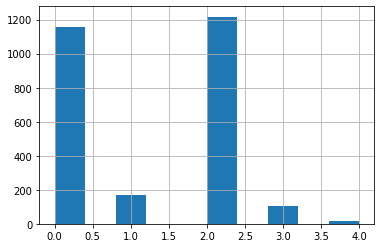

In [507]:
df_bin['trauma_doenca'].hist()

In [508]:
## Importando biblioteca para fazer a divisão da base entre teste/treino
from sklearn.model_selection import train_test_split
df_train_set, df_test_set = train_test_split(df_bin, test_size=0.25, random_state=42, stratify=df_bin['trauma_doenca'])

In [509]:
X_train = df_train_set.drop('analise_do_contexto', axis=1)
y_train = df_train_set['analise_do_contexto']

X_test = df_test_set.drop('analise_do_contexto', axis=1)
y_test = df_test_set['analise_do_contexto']

In [510]:
X_train.head()

,trauma_doenca,autoconfianca,autocontrole,conquistar_e_manter_pessoas,empatia,leitura_corporal,otimismo_com_a_vida,sentido_da_vida
1003,0,3.79,15.15,4.8,4.77,5.78,15.15,18.33
333,3,15.15,5.05,9.09,3.77,-0.25,14.14,18.33
1113,0,-5.05,3.79,20.2,9.05,-5.03,1.01,-9.52
1869,3,-4.04,-3.03,-2.02,-4.27,0.0,-4.04,0.92
654,0,8.84,8.84,3.79,5.86,0.0,5.81,5.86


## Análise exploratória dos dados

In [511]:
#Normalizando os dados
X_train.columns

Index(['trauma_doenca', 'autoconfianca', 'autocontrole',
       'conquistar_e_manter_pessoas', 'empatia', 'leitura_corporal',
       'otimismo_com_a_vida', 'sentido_da_vida'],
      dtype='object')

In [512]:
num_attributes = X_train.columns
X_train[num_attributes].head()

,trauma_doenca,autoconfianca,autocontrole,conquistar_e_manter_pessoas,empatia,leitura_corporal,otimismo_com_a_vida,sentido_da_vida
1003,0,3.79,15.15,4.8,4.77,5.78,15.15,18.33
333,3,15.15,5.05,9.09,3.77,-0.25,14.14,18.33
1113,0,-5.05,3.79,20.2,9.05,-5.03,1.01,-9.52
1869,3,-4.04,-3.03,-2.02,-4.27,0.0,-4.04,0.92
654,0,8.84,8.84,3.79,5.86,0.0,5.81,5.86


In [513]:
from sklearn.preprocessing import RobustScaler

In [514]:
transformer = RobustScaler()
transformer.fit(X_train[num_attributes])

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [515]:
X_train[num_attributes] = transformer.transform(X_train[num_attributes])

In [516]:
X_train[num_attributes].head()

,trauma_doenca,autoconfianca,autocontrole,conquistar_e_manter_pessoas,empatia,leitura_corporal,otimismo_com_a_vida,sentido_da_vida
1003,-1.0,-0.310109,1.321075,-0.160063,0.000000,0.343003,0.840684,0.692946
333,0.5,1.241803,-0.107496,0.519810,-0.142248,-0.686007,0.749775,0.692946
1113,-1.0,-1.517760,-0.285714,2.280507,0.608819,-1.501706,-0.432043,-1.233057
1869,0.5,-1.379781,-1.250354,-1.240887,-1.285917,-0.643345,-0.886589,-0.511065
654,-1.0,0.379781,0.428571,-0.320127,0.155050,-0.643345,0.000000,-0.169433


In [517]:
X_test[num_attributes] = transformer.transform(X_test[num_attributes])

##Machine Learning

Treinando e Avaliando no Conjunto de Treino

In [518]:
#Regressão Logística
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

In [519]:
X, y = load_iris(return_X_y=True)
lreg = LogisticRegression(random_state=0)
lreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [535]:
lin_reg.predict(X_test.head(10))

array(['4.02', '5.03', '5.03', '13.07', '3.02', '0.92', '0.92', '5.86',
       '0.92', '0.92'], dtype=object)

In [521]:
#Arvore de Decisão
from sklearn.tree import DecisionTreeRegressor

In [522]:
tree_reg = DecisionTreeRegressor()

In [523]:
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [524]:
y_prediction_train = tree_reg.predict(X_train)

In [525]:
#Arvore de decisão para treino
tree_rnse = np.sqrt(mean_squared_error(y_train, y_prediction_train))
tree_rnse

1.4475537224895362e-17

In [526]:
#Arvore de decisão para teste
y_prediction_test = tree_reg.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_prediction_test))

5.116841112299242

Estimativa com validação cruzada

In [536]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(tree_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
tree_error = np.sqrt(-score)

In [530]:
np.mean(tree_error)

5.171959969601529

In [531]:
np.std(tree_error)

0.20619692732759307

In [532]:
#Replicando para regressao linear
score = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
lr_error = np.sqrt(-score)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown

In [533]:
np.mean(lr_error)

4.372718321940157

In [534]:
np.std(lr_error)

0.13400868243833317

Métricas para avaliação

In [538]:
#Matriz de Confusão
from sklearn.metrics import confusion_matrix

In [539]:
confusion_matrix(y_test, y_prediction_test)

ValueError: ignored